# Notebook 2: Improvements on the Initial Model #

After trying the model on some real snowy images in the streamlit app, it looks like the first model isn't generalizing well to pictures with real snowfall, despite very strong metrics on the test data sets.  Unfortunately, the most likely reason for this is that the masks do not produce images that look enough like real snow.  A better dataset is the best solution, but it may be difficult and time-consuming to come by.

Meanwhile, I'm hopeful that regularization and a simpler architecture will improve the performance of this model on real images.  It's possible that the model is overfitting on the shape of the fake snow flakes.  If I can adjust it in such a way that it focuses more on the presence of flakes and less on their shapes, performance on real images may improve.

In this notebook, the following steps are taken:
- Fit a second model for comparison with the first model.
- Compute and save predictions on the training and validation data for both models that contain the original prediction values as floats
- Examine the effects of different cutoff values on the classification metrics.
- Make final recommendations for the current models and choose a model and cutoff for use in a streamlit app
- Discuss future directions for this project.

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from sklearn.metrics import classification_report

import json

import snow_tools as st

from tensorflow.data import AUTOTUNE
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

Prepare the Tensorflow Datasets in the same manner as was done previously.

In [2]:
# Create Tensorflow Dataset objects for training.
folders = ['../data/train/clear/', '../data/train/snow/']
train_data, val_data = st.get_train_data(folders, shuffle_seed=632, train_size=0.8)

In [3]:
# Create Tensorflow Dataset objects for the test images.
folders = ['../data/test/small/clear/', '../data/test/small/snow/',
         '../data/test/medium/clear/', '../data/test/medium/snow/',
         '../data/test/large/clear/', '../data/test/large/snow/']
test_small, test_medium, test_large = st.get_test_data(folders, shuffle_seed=294)

### Section VI: Train a Second Neural Net ###

Although the neural net trained in Notebook 1, test1, performed very well, I noticed while designing the streamlit app that it seemed to struggle to recognize more realistic pictures of falling snow, especially when the snow was wet or the flakes were small.  I'm training a new neural net with slightly smaller convolution kernels and larger MaxPooling kernels to try to highlight those smaller snowflakes.  I'm also allowing the model to train for 10 epochs, rather than 5.

A more proper gridsearch process would certainly be helpful, but would also be quite time-consuming, even with CUDA.  The original model already performed very well on the synthetic snow images in this dataset.  The problem of identifying wet or light snowfall may need to be addressed by training on a dataset containing more realistic snow pictures.  These considerations will be addressed as possibilities for future work in the Conclusions.

In [4]:
# Batch datasets and tell Tensorflow to fetch the next batch while each batch is being fit.

batch_size = 32

train_data = train_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
val_data = val_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
test_small = test_small.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
test_medium = test_medium.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
test_large = test_large.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [5]:
model = Sequential()

model.add(layers.Conv2D(filters=8, kernel_size=(5, 5),
                        activation='leaky_relu',
                        padding='same',
                        input_shape=[640, 640, 3]))

model.add(layers.MaxPooling2D(pool_size=(5,5)))

model.add(layers.Flatten())

model.add(layers.Dense(32, activation='leaky_relu'))

model.add(layers.Dense(1, activation='sigmoid'))

In [6]:
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [7]:
# Train the neural net.
history = model.fit(train_data, validation_data=val_data, epochs=5, verbose=1)

Epoch 1/5
2500/2500 [==============================] - 467s 184ms/step - loss: 0.6490 - accuracy: 0.7251 - val_loss: 0.5302 - val_accuracy: 0.7620
Epoch 2/5
2500/2500 [==============================] - 469s 187ms/step - loss: 0.4565 - accuracy: 0.7934 - val_loss: 0.4823 - val_accuracy: 0.7943
Epoch 3/5
2500/2500 [==============================] - 469s 188ms/step - loss: 0.3847 - accuracy: 0.8302 - val_loss: 0.4241 - val_accuracy: 0.8134
Epoch 4/5
2500/2500 [==============================] - 476s 190ms/step - loss: 0.3354 - accuracy: 0.8526 - val_loss: 0.4847 - val_accuracy: 0.7958
Epoch 5/5
2500/2500 [==============================] - 466s 186ms/step - loss: 0.2944 - accuracy: 0.8739 - val_loss: 0.3978 - val_accuracy: 0.8340


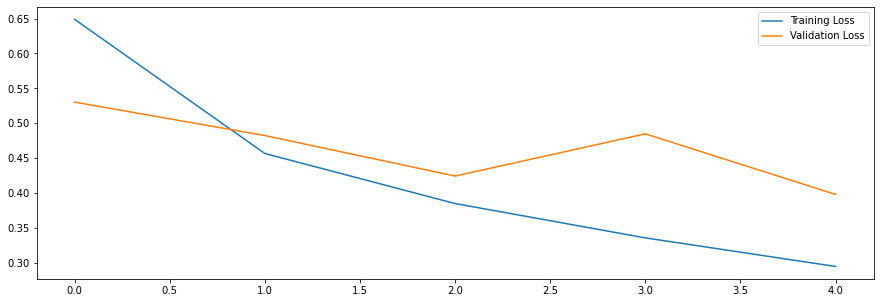

In [8]:
# Plot of the training and validation loss for each epoch.
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend();

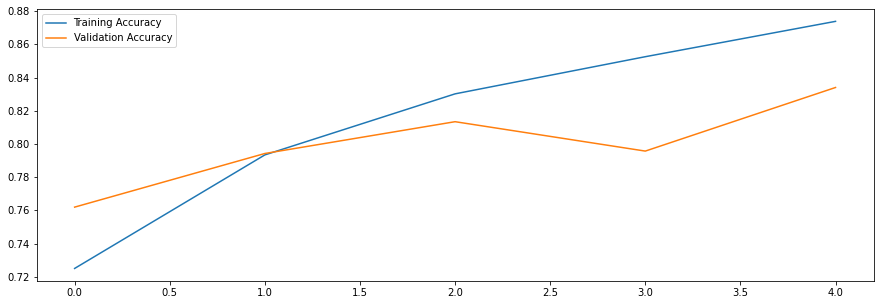

In [9]:
# Plot of the training and validation accuracy for each epoch.
plt.figure(figsize=(15,5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend();

### Section VII: Save model2 and Save Predictions from Both Models as Floats ###

Model and training history saved according to the same process as in Notebook 1.

In [10]:
model_name = 'model1'

In [11]:
model.save(f'../saved_models/{model_name}/trained_model.pickle')

INFO:tensorflow:Assets written to: ../saved_models/model1/trained_model.pickle\assets


In [12]:
history_dict = history.history
json.dump(history_dict, open(f'../saved_models/{model_name}/training_hist.json', 'w'))

In [13]:
st.get_train_preds(train_data, model, model_name, 'train')

In [14]:
st.get_train_preds(val_data, model, model_name, 'val')

In [15]:
st.get_test_preds(test_small, model, model_name, 'test_small')

In [16]:
st.get_test_preds(test_medium, model, model_name, 'test_medium')

In [17]:
st.get_test_preds(test_large, model, model_name, 'test_large')

In [18]:
load_model_name = 'model1'

In [19]:
loaded_model = load_model(f'../saved_models/{load_model_name}/trained_model.pickle')

In [20]:
loaded_history_dict = json.load(open(f'../saved_models/{load_model_name}/training_hist.json', 'r'))

In [21]:
preds_dict = {
    'train' : pd.read_csv(f'../saved_models/{load_model_name}/train_preds.csv'),
    'val' : pd.read_csv(f'../saved_models/{load_model_name}/val_preds.csv'),
    'test_small' : pd.read_csv(f'../saved_models/{load_model_name}/test_small_preds.csv'),
    'test_medium' : pd.read_csv(f'../saved_models/{load_model_name}/test_medium_preds.csv'),
    'test_large' : pd.read_csv(f'../saved_models/{load_model_name}/test_large_preds.csv')
}

train:

              precision    recall  f1-score   support

       clear     0.8612    0.9244    0.8917     40000
        snow     0.9184    0.8510    0.8834     40000

    accuracy                         0.8877     80000
   macro avg     0.8898    0.8877    0.8875     80000
weighted avg     0.8898    0.8877    0.8875     80000

ROC AUC score: 0.8876999999999999

*************************

val:

              precision    recall  f1-score   support

       clear     0.8111    0.8709    0.8399     10000
        snow     0.8606    0.7972    0.8277     10000

    accuracy                         0.8340     20000
   macro avg     0.8359    0.8340    0.8338     20000
weighted avg     0.8359    0.8340    0.8338     20000

ROC AUC score: 0.8340500000000001

*************************

test_small:

              precision    recall  f1-score   support

       clear     0.7531    0.8871    0.8146     16611
        snow     0.8627    0.7092    0.7784     16611

    accuracy                   

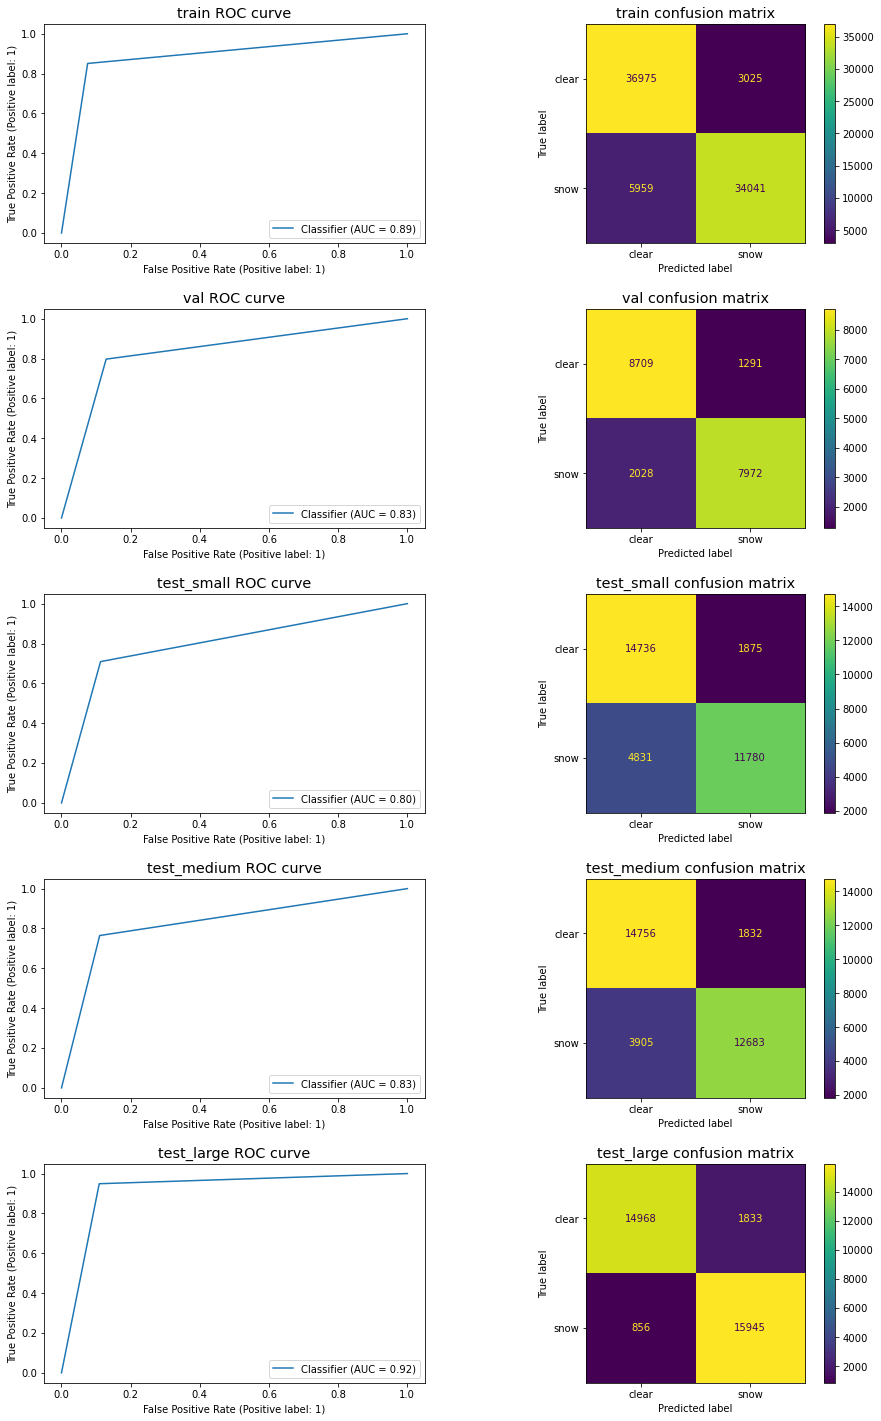

In [22]:
st.check_metrics(preds_dict, 'clear', 'snow', 0.5)

The fact that this model, with its simpler architecture, is reaching about 80% accuracy on test data while overfitting on training data makes me hopeful that it's focusing more on broad details and not moemorizing snowflake shapes.  This is better for recognition of snow of various shapes in differing conditions and settings.  I think this neural net will perform better by focusing on broad patterns rather than little details.

The fact that the model is clearly overfitting to the training data relative to the validation and test data strongly suggests than some regularization will help.  Since I have only one hidden dense layer and an output layer, I will try l2 regularization, rather than dropout.

In [25]:
model = Sequential()

model.add(layers.Conv2D(filters=8, kernel_size=(5, 5),
                        activation='leaky_relu',
                        padding='same',
                        input_shape=[640, 640, 3]))

model.add(layers.MaxPooling2D(pool_size=(5,5)))

model.add(layers.Flatten())

model.add(layers.Dense(32, activation='leaky_relu', kernel_regularizer=l2()))

model.add(layers.Dense(1, activation='sigmoid'))

In [26]:
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [27]:
# Train the neural net.
history = model.fit(train_data, validation_data=val_data, epochs=5, verbose=1)

Epoch 1/5
2500/2500 [==============================] - 451s 180ms/step - loss: 0.7416 - accuracy: 0.7220 - val_loss: 0.6509 - val_accuracy: 0.7230
Epoch 2/5
2500/2500 [==============================] - 473s 189ms/step - loss: 0.6400 - accuracy: 0.7505 - val_loss: 0.6435 - val_accuracy: 0.7313
Epoch 3/5
2500/2500 [==============================] - 474s 189ms/step - loss: 0.5864 - accuracy: 0.7672 - val_loss: 0.5814 - val_accuracy: 0.7738
Epoch 4/5
2500/2500 [==============================] - 474s 190ms/step - loss: 0.5612 - accuracy: 0.7816 - val_loss: 0.5672 - val_accuracy: 0.7663
Epoch 5/5
2500/2500 [==============================] - 477s 191ms/step - loss: 0.5576 - accuracy: 0.7833 - val_loss: 0.5265 - val_accuracy: 0.7915


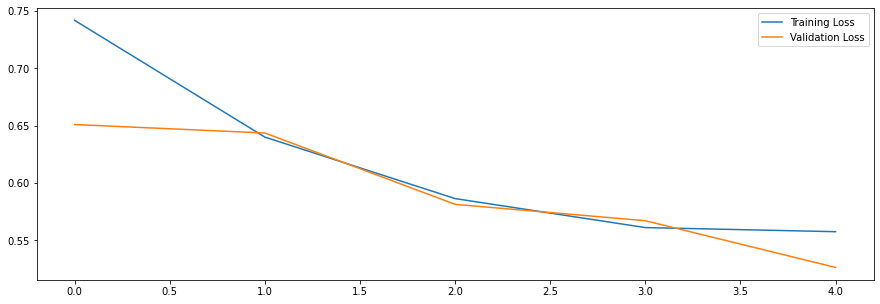

In [28]:
# Plot of the training and validation loss for each epoch.
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend();

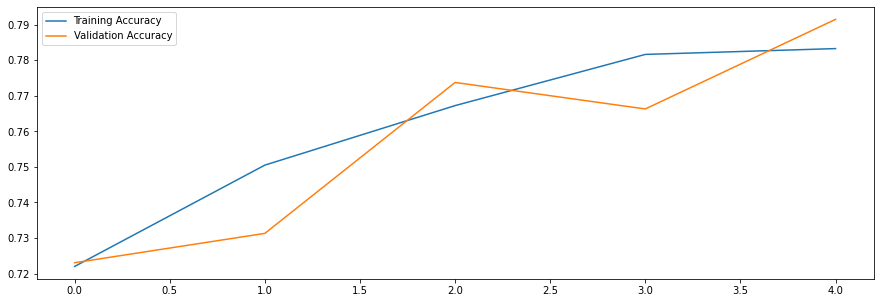

In [29]:
# Plot of the training and validation accuracy for each epoch.
plt.figure(figsize=(15,5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend();

### Section VII: Save model2 and Save Predictions from Both Models as Floats ###

Model and training history saved according to the same process as in Notebook 1.

In [30]:
model_name = 'model2'

In [31]:
model.save(f'../saved_models/{model_name}/trained_model.pickle')

INFO:tensorflow:Assets written to: ../saved_models/model2/trained_model.pickle\assets


In [32]:
history_dict = history.history
json.dump(history_dict, open(f'../saved_models/{model_name}/training_hist.json', 'w'))

In [33]:
st.get_train_preds(train_data, model, model_name, 'train')

In [34]:
st.get_train_preds(val_data, model, model_name, 'val')

In [35]:
st.get_test_preds(test_small, model, model_name, 'test_small')

In [36]:
st.get_test_preds(test_medium, model, model_name, 'test_medium')

In [37]:
st.get_test_preds(test_large, model, model_name, 'test_large')

In [38]:
load_model_name = 'model1'

In [39]:
loaded_model = load_model(f'../saved_models/{load_model_name}/trained_model.pickle')

In [40]:
loaded_history_dict = json.load(open(f'../saved_models/{load_model_name}/training_hist.json', 'r'))

In [41]:
preds_dict = {
    'train' : pd.read_csv(f'../saved_models/{load_model_name}/train_preds.csv'),
    'val' : pd.read_csv(f'../saved_models/{load_model_name}/val_preds.csv'),
    'test_small' : pd.read_csv(f'../saved_models/{load_model_name}/test_small_preds.csv'),
    'test_medium' : pd.read_csv(f'../saved_models/{load_model_name}/test_medium_preds.csv'),
    'test_large' : pd.read_csv(f'../saved_models/{load_model_name}/test_large_preds.csv')
}

train:

              precision    recall  f1-score   support

       clear     0.8612    0.9244    0.8917     40000
        snow     0.9184    0.8510    0.8834     40000

    accuracy                         0.8877     80000
   macro avg     0.8898    0.8877    0.8875     80000
weighted avg     0.8898    0.8877    0.8875     80000

ROC AUC score: 0.8876999999999999

*************************

val:

              precision    recall  f1-score   support

       clear     0.8111    0.8709    0.8399     10000
        snow     0.8606    0.7972    0.8277     10000

    accuracy                         0.8340     20000
   macro avg     0.8359    0.8340    0.8338     20000
weighted avg     0.8359    0.8340    0.8338     20000

ROC AUC score: 0.8340500000000001

*************************

test_small:

              precision    recall  f1-score   support

       clear     0.7531    0.8871    0.8146     16611
        snow     0.8627    0.7092    0.7784     16611

    accuracy                   

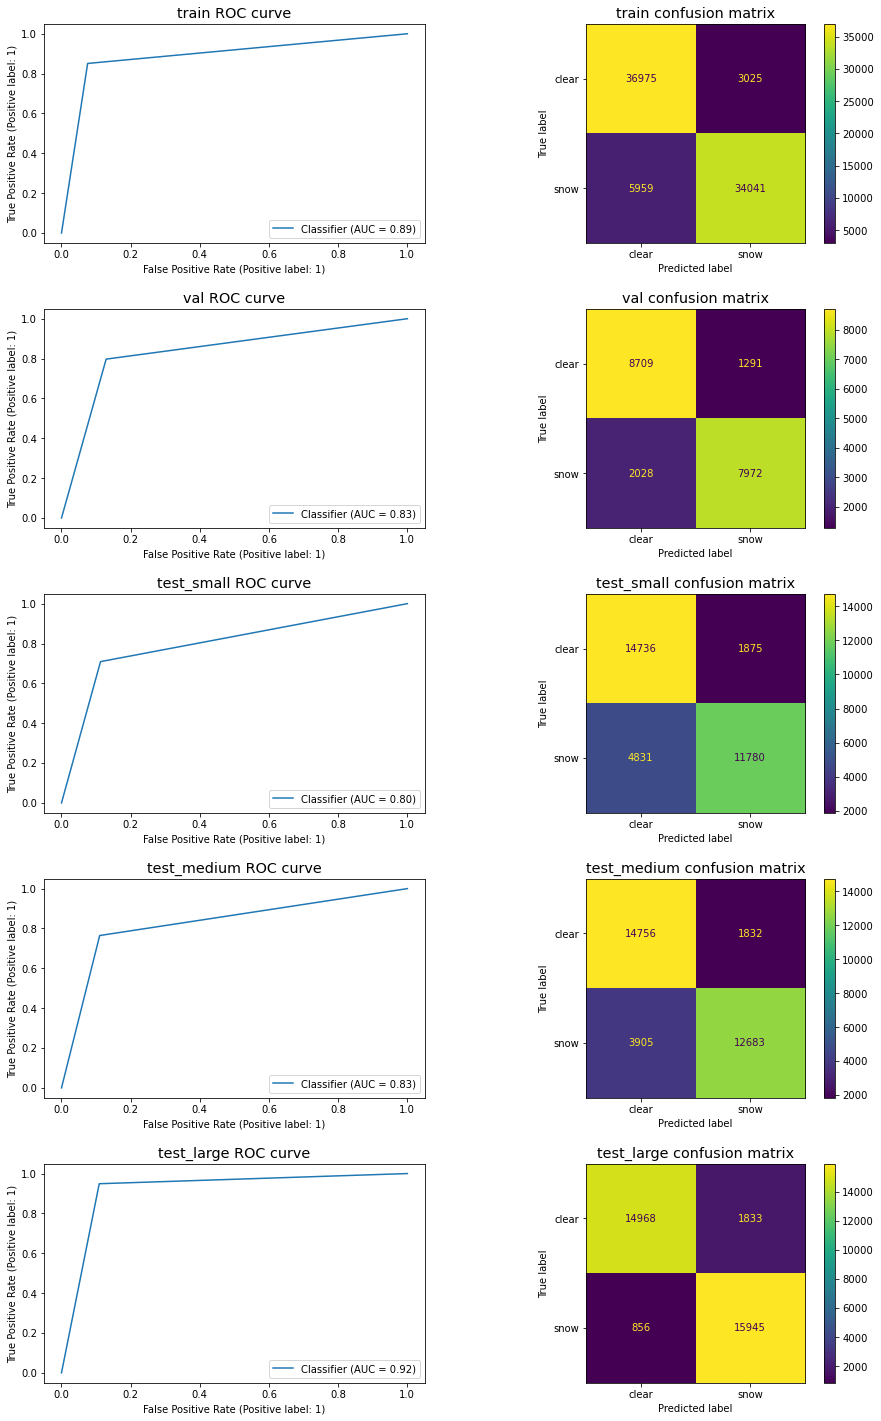

In [42]:
st.check_metrics(preds_dict, 'clear', 'snow', 0.5)

### Section VIII: Comparison of Thresholds for Snow Classification ###

I begin by reloading the predictions made by test1 as floats.

In [14]:
load_model_name = 'test1_float_shuffle_once'

In [111]:
# This function assigns a given number to either 0 or 1 according to a given cutoff.
def binarize_class(in_num, cutoff):
    if in_num < cutoff:
        return 0
    else:
        return 1

In [93]:
# This function applies binarize_class to generate a new column of binary predictions for the input dataframes
# according to a given cutoff.  It then calls check_metrics to display classification metrics.
def check_cutoff(train_pred_df, val_pred_df, cutoff):
    train_pred_df['pred_binary'] = train_pred_df['pred'].apply(binarize_class, args=(cutoff,))
    val_pred_df['pred_binary'] = val_pred_df['pred'].apply(binarize_class, args=(cutoff,))
    mts.check_metrics(train_pred_df['pred_binary'],
                  val_pred_df['pred_binary'],
                  train_pred_df['true'],
                  val_pred_df['true'],
                  'clear', 'snow')

In [94]:
# Calculate precision, recall, f1 score, and accuracy of snow identification for 39 different cutoffs.
snow_cutoffs = []
snow_precisions = []
snow_recalls = []
snow_f1_scores = []
accuracies = []
for snow_cutoff in np.linspace(.025, .975, 39):
    val_pred_df['pred_binary'] = val_pred_df['pred'].apply(binarize_class, args=(snow_cutoff,))
    report = classification_report(val_pred_df['true'], val_pred_df['pred_binary'], target_names=['clear', 'snow'], output_dict=True)
    snow_cutoffs.append(snow_cutoff)
    snow_precisions.append(report['snow']['precision'])
    snow_recalls.append(report['snow']['recall'])
    snow_f1_scores.append(report['snow']['f1-score'])
    accuracies.append(report['accuracy'])

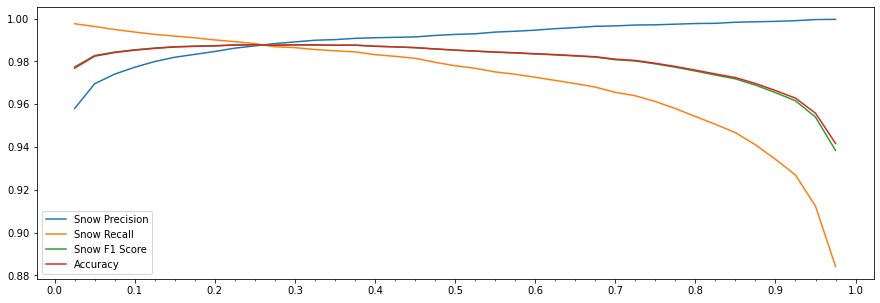

In [96]:
# Plot the precision, recall, f1 score, and accuracty of snow identification for each cutoff.
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(snow_cutoffs, snow_precisions, label='Snow Precision')
ax.plot(snow_cutoffs, snow_recalls, label='Snow Recall')
ax.plot(snow_cutoffs, snow_f1_scores, label='Snow F1 Score')
ax.plot(snow_cutoffs, accuracies, label='Accuracy')
ax.xaxis.set_major_locator(MultipleLocator(.1))
ax.xaxis.set_minor_locator(MultipleLocator(.025))
ax.legend();

This graph shows how precision, recall, f1 score, and accuracy vary over a wide range of possible cutoff values for snow classification.  All values converge where precision and recall are equal, around a cutoff of about 0.25.  Conveniently, accuracy is also at its maximum near this point, and it drops off only gradually as the cutoff is shifted.  If desired, the cutoff could be shifted lower for an increase in recall at the expense of precision with minimal overall accuracy loss.

In [97]:
zipped = list(zip(snow_cutoffs, accuracies))

cut_high, acc_high = zipped[0]
for cut, acc in zipped[1:]:
    if acc > acc_high:
        acc_high = acc
        cut_high = cut

cut_high,acc_high

(0.24999999999999997, 0.98775)

The above cell confirms that, of the 39 cutoffs checked, 0.25 gives the highest accuracy.

Train Data Metrics:

              precision    recall  f1-score   support

       clear     0.9777    0.9934    0.9855     39975
        snow     0.9933    0.9773    0.9853     40025

    accuracy                         0.9854     80000
   macro avg     0.9855    0.9854    0.9854     80000
weighted avg     0.9855    0.9854    0.9854     80000

ROC AUC score: 0.9853800255390724

*************************

Test Data Metrics:

              precision    recall  f1-score   support

       clear     0.9781    0.9927    0.9853      9956
        snow     0.9926    0.9780    0.9853     10044

    accuracy                         0.9853     20000
   macro avg     0.9854    0.9853    0.9853     20000
weighted avg     0.9854    0.9853    0.9853     20000

ROC AUC score: 0.985332276032864

*************************



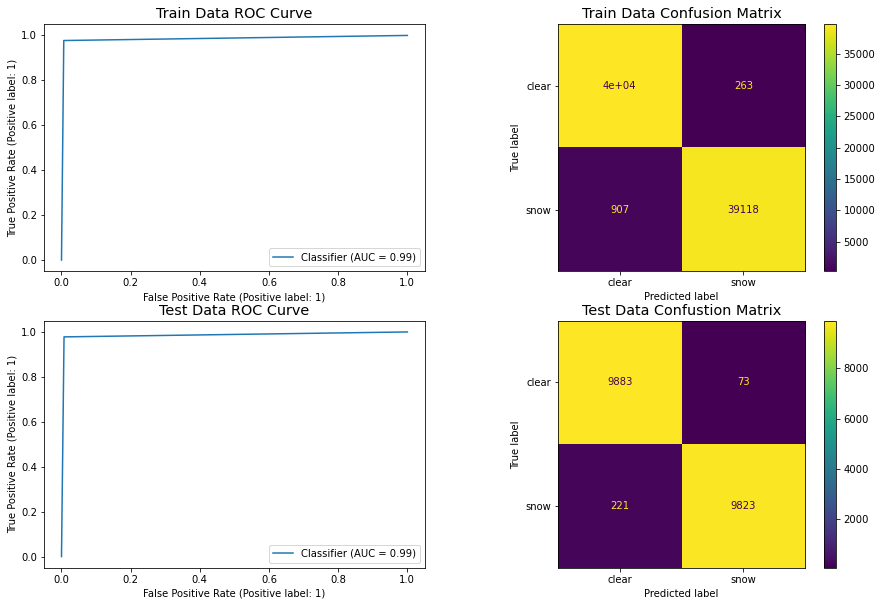

In [98]:
check_cutoff(train_pred_df, val_pred_df, 0.5)

Full classification metrics for the default cutoff of 0.5, as seen in Notebook 1.  Precision significantly exceeds recall when detecting snow, which is likely not ideal for an automated snow detection system in which failure to detect snow is probably worse than falsely detecting snow.

Train Data Metrics:

              precision    recall  f1-score   support

       clear     0.9883    0.9864    0.9874     39975
        snow     0.9865    0.9883    0.9874     40025

    accuracy                         0.9874     80000
   macro avg     0.9874    0.9874    0.9874     80000
weighted avg     0.9874    0.9874    0.9874     80000

ROC AUC score: 0.9873744013181256

*************************

Test Data Metrics:

              precision    recall  f1-score   support

       clear     0.9882    0.9871    0.9877      9956
        snow     0.9873    0.9884    0.9878     10044

    accuracy                         0.9878     20000
   macro avg     0.9878    0.9877    0.9877     20000
weighted avg     0.9878    0.9878    0.9877     20000

ROC AUC score: 0.9877473427885565

*************************



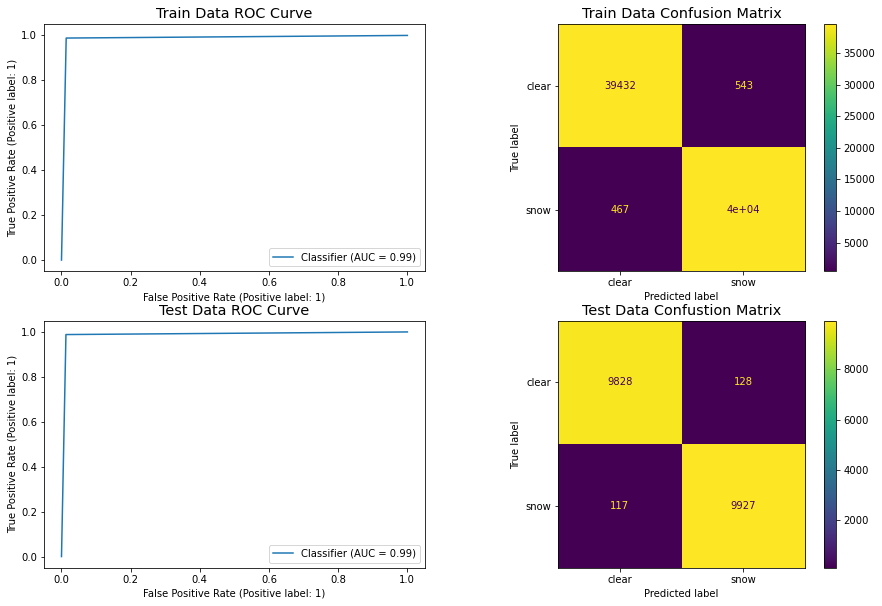

In [99]:
check_cutoff(train_pred_df, val_pred_df, 0.25)

Classification metrics with a cutoff of 0.25.  In addition to a slightly improved overall accuracy, this cutoff gives us nearly identical precision and recall.  If desired, an even lower cutoff can be used to optimize the model for high recall.

I now reload model2.

In [101]:
load_model_name = 'model2_shuffle_once'

In [102]:
train_pred_df = pd.read_csv(f'../saved_models/{load_model_name}_train.csv')
val_pred_df = pd.read_csv(f'../saved_models/{load_model_name}_val.csv')

The two cells below are identical to those used above to compare cutoffs.  If the future, they will likely be wrapped into a function to reduce repetition.

In [103]:
snow_cutoffs = []
snow_precisions = []
snow_recalls = []
snow_f1_scores = []
accuracies = []
for snow_cutoff in np.linspace(.025, .975, 39):
    val_pred_df['pred_binary'] = val_pred_df['pred'].apply(binarize_class, args=(snow_cutoff,))
    report = classification_report(val_pred_df['true'], val_pred_df['pred_binary'], target_names=['clear', 'snow'], output_dict=True)
    snow_cutoffs.append(snow_cutoff)
    snow_precisions.append(report['snow']['precision'])
    snow_recalls.append(report['snow']['recall'])
    snow_f1_scores.append(report['snow']['f1-score'])
    accuracies.append(report['accuracy'])

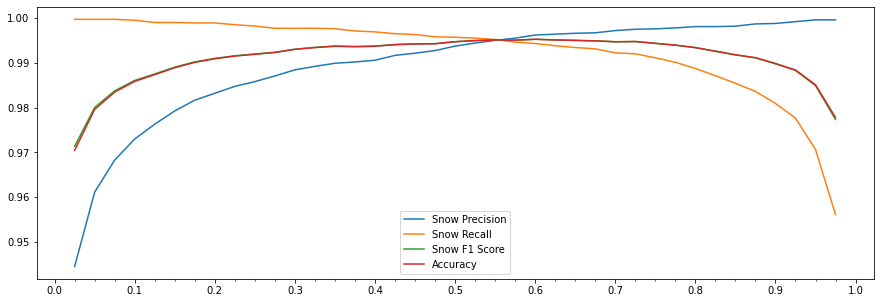

In [104]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(snow_cutoffs, snow_precisions, label='Snow Precision')
ax.plot(snow_cutoffs, snow_recalls, label='Snow Recall')
ax.plot(snow_cutoffs, snow_f1_scores, label='Snow F1 Score')
ax.plot(snow_cutoffs, accuracies, label='Accuracy')
ax.xaxis.set_major_locator(MultipleLocator(.1))
ax.xaxis.set_minor_locator(MultipleLocator(.025))
ax.legend();

The ideal cutoffs for model2 differ significantly from those for test1.  As confirmed in the cell below, the maximum accuracy is now at a cutoff of 0.6  It's possible that model2 has better-centered predictions due to being trained for twice as many epochs.  It's also possible that decreasing the convolution kernel and increaseing the pooling kernel increased the model's sensitivity to snow, as intended.

The cutoff at which precision and recall are equal is even closer to 0.5 than the cutoff that produces maximum accuracy.  In this case, choosing maximum accuracy will result in precision of snow detection being slightly higher than recall.  However, the accuracy dropoff is still slow, with accuracy remaining above 99% for a very wide range of cutoffs.  This allows for the model to be highly tuned to favor precision or recall as the situation requires.

In [106]:
zipped = list(zip(snow_cutoffs, accuracies))

cut_high, acc_high = zipped[0]
for cut, acc in zipped[1:]:
    if acc > acc_high:
        acc_high = acc
        cut_high = cut

cut_high,acc_high

(0.6, 0.99525)

Train Data Metrics:

              precision    recall  f1-score   support

       clear     0.9963    0.9941    0.9952     40134
        snow     0.9941    0.9963    0.9952     39866

    accuracy                         0.9952     80000
   macro avg     0.9952    0.9952    0.9952     80000
weighted avg     0.9952    0.9952    0.9952     80000

ROC AUC score: 0.9952286314533164

*************************

Test Data Metrics:

              precision    recall  f1-score   support

       clear     0.9957    0.9937    0.9947      9983
        snow     0.9937    0.9957    0.9947     10017

    accuracy                         0.9947     20000
   macro avg     0.9947    0.9947    0.9947     20000
weighted avg     0.9947    0.9947    0.9947     20000

ROC AUC score: 0.9946982846780428

*************************



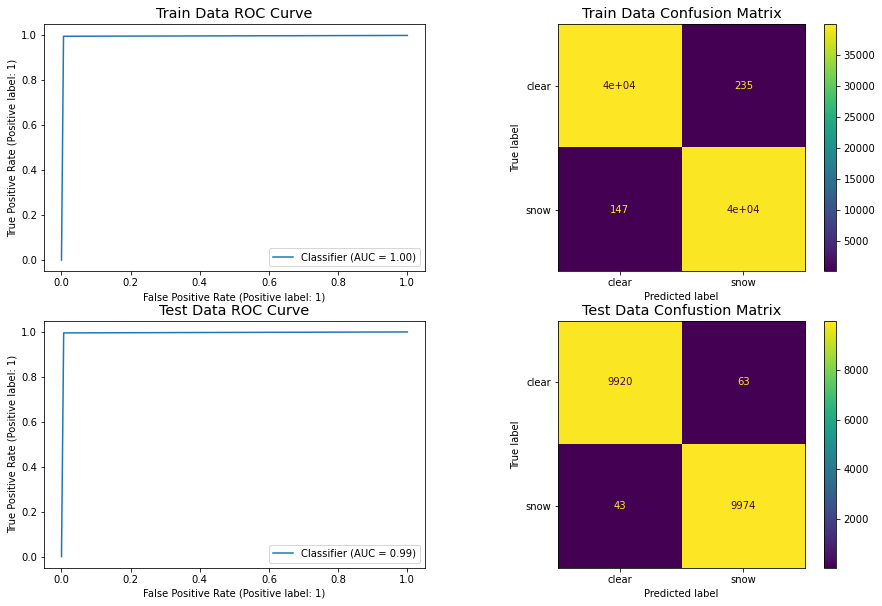

In [108]:
check_cutoff(train_pred_df, val_pred_df, 0.5)

Classification metrics for model2 with the default cutoff of 0.5.  Recall is slighlty higher than precision, but precsion, recall, and accuracy are all comfortably above 99%.

Train Data Metrics:

              precision    recall  f1-score   support

       clear     0.9958    0.9951    0.9954     40134
        snow     0.9950    0.9957    0.9954     39866

    accuracy                         0.9954     80000
   macro avg     0.9954    0.9954    0.9954     80000
weighted avg     0.9954    0.9954    0.9954     80000

ROC AUC score: 0.9954011208890792

*************************

Test Data Metrics:

              precision    recall  f1-score   support

       clear     0.9952    0.9950    0.9951      9983
        snow     0.9950    0.9952    0.9951     10017

    accuracy                         0.9951     20000
   macro avg     0.9951    0.9951    0.9951     20000
weighted avg     0.9951    0.9951    0.9951     20000

ROC AUC score: 0.9950998158384677

*************************



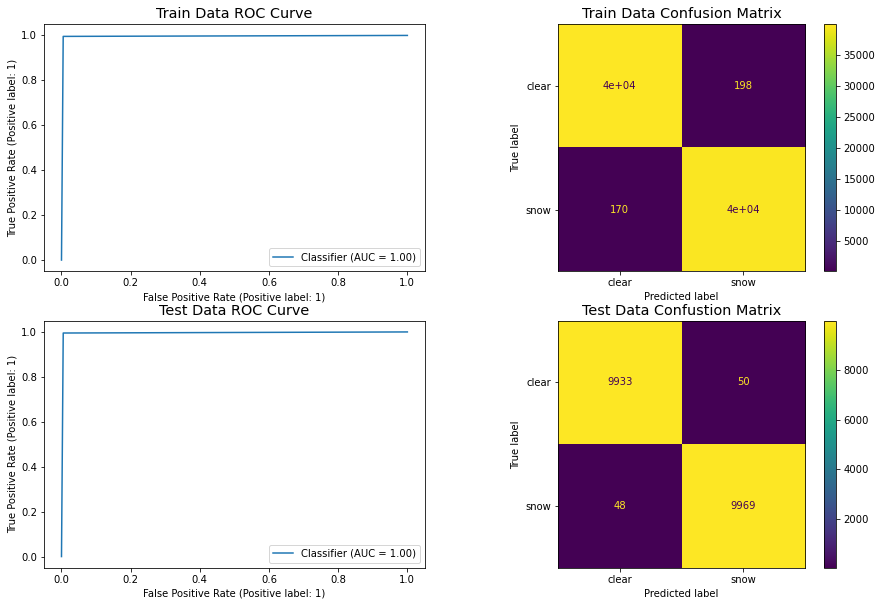

In [110]:
check_cutoff(train_pred_df, val_pred_df, 0.55)

Classification metrics for model2 with a cutoff of 0.55.  This results in an accuracy between those achieved with cutoffs at 0.5 and 0.6 (0.6 providing the max accuracy among all cutoffs tested).  Compared with the cutoff of 0.5, precison improves at the expense of a small amount of recall, and precision and recall are essentially identical.

### Section IX: Recommendations and Future Directions. ###

The models created here have shown great potential for snow detection in images.  For the streamlit app, I will use model2 and a snow classification cutoff of 0.55.  This gives precision, recall, and accuracy of 99.5% on the validation data.  In addition to being slightly better performing, model2 is smaller than test1 at less than 1 MB.  This makes it ideal for deployment on streamlit.

There is great potential for future work in this project.
- The synthetic dataset has advantages.  The fact that the images are identical aside from the apparent snow means that the model cannot classify images based on anything else.  However, the model should be tested in real-world conditions to determine how well it performs with real snow.  Gathering a large amount of such data may not be easy, but public webcams such as traffic cameras could be an excellent place to begin.
- In-depth analysis of the failure cases could be very helpful for understanding the limitations of the model.
- With the models being slightly underfit, there is room for more extensive tuning and training, which could improve the models' performance even further.  This may not be necessary right now, given the small size and high accuracy of the models, but it may be necessary to modify them for future applications, discussed further below.  In that case, further hyperparameter tuning and more training epochs may be useful.  Optimization methods, such as transfer learning, pruning, and quantization, may also be necessary for applications that demand very quick predictions and/or a more complex model.
- The streamlit app that identifies falling snow in a single image can be expanded upon.  A website that uses these models to identify snowfall in a video or a live feed from a webcam via API (likely on a short delay), would greatly expand the possible applications.  Automatic snow detection in a traffic camera could be useful to emergency and transit authorities, or even for ski resorts.  The current models may be quick and small enough for the task, but it may also be necessary to use a more sophisticated model such as YOLO.
- Finally, this project can be taken beyond snow detection.  Prior work in this area includes removal of snow from images using a Generative Adversarial Network, which was the original use for the dataset I have been using in this project.